# This script demonstrates the linearization of the "moons" data sets

In [1]:
import vae_tools # Always import first to define if keras or tf.kreas should be used
import vae_tools.sanity
import vae_tools.viz
import vae_tools.callbacks
from vae_tools.mmvae import MmVae, ReconstructionLoss
vae_tools.sanity.check()
import tensorflow as tf
import keras
from keras.layers import Input, Dense, Lambda, Layer
import numpy as np
from scipy.stats import norm
# Set the seed for reproducible results
import vae_tools.sampling
# resize the notebook if desired
#vae_tools.nb_tools.notebook_resize()
import matplotlib
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

Using TensorFlow backend.


python version:  3.5.2
keras version: 2.2.4
tensorflow version: 1.12.0
matplotlib uses:  module://ipykernel.pylab.backend_inline
Available GPUs ['/job:localhost/replica:0/task:0/device:GPU:0']


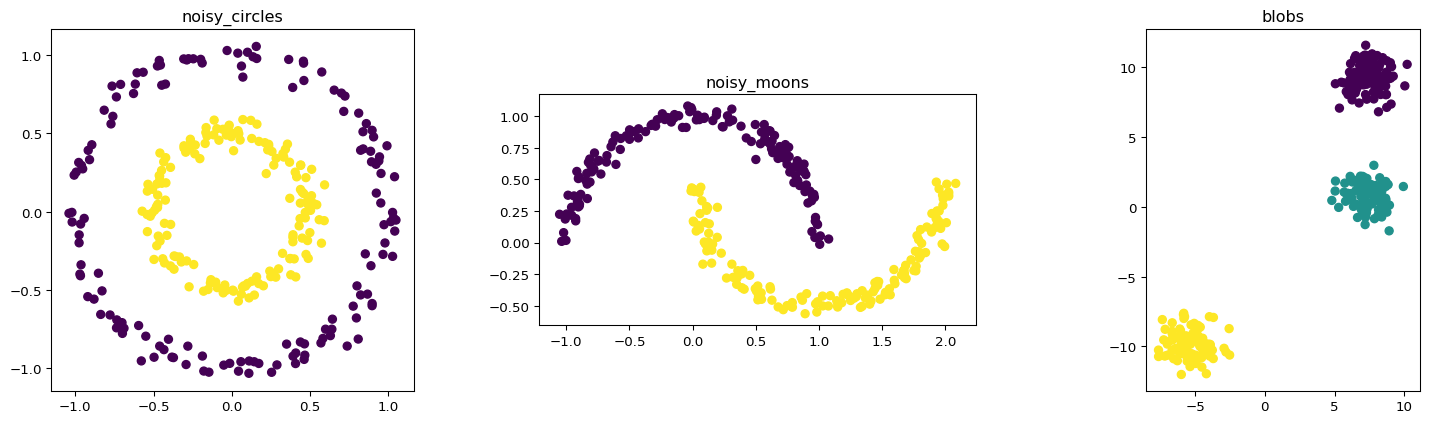

In [2]:
from sklearn import datasets
n_samples = 30000
train_perc = 0.99
n_train_samples = int(n_samples * train_perc)
n_test_samples = int(n_samples - n_train_samples)
x_noisy_circles, y_noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05)
x_noisy_moons, y_noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
x_blobs, y_blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
x_roll, y_roll = datasets.make_swiss_roll(n_samples=n_samples, noise=0.05)

f, axs = plt.subplots(1,3,figsize=(20,5), dpi=96)
axs[0].scatter(x_noisy_circles[-n_test_samples:, 0], x_noisy_circles[-n_test_samples:, 1], c=y_noisy_circles[-n_test_samples:])
axs[1].scatter(x_noisy_moons[-n_test_samples:, 0], x_noisy_moons[-n_test_samples:, 1], c=y_noisy_moons[-n_test_samples:])
axs[2].scatter(x_blobs[-n_test_samples:, 0], x_blobs[-n_test_samples:, 1], c=y_blobs[-n_test_samples:])
axs[0].set_title("noisy_circles")
axs[1].set_title("noisy_moons")
axs[2].set_title("blobs")
axs[0].set_aspect('equal')
axs[1].set_aspect('equal')
axs[2].set_aspect('equal')
plt.show()

x_train, y_train, x_test, y_test = x_noisy_moons[:n_train_samples], y_noisy_moons[:n_train_samples], x_noisy_moons[-n_test_samples:], y_noisy_moons[-n_test_samples:]
#x_train, y_train, x_test, y_test = x_noisy_circles[:n_train_samples], y_noisy_circles[:n_train_samples], x_noisy_circles[-n_test_samples:], y_noisy_circles[-n_test_samples:]
#x_train, y_train, x_test, y_test = x_roll[:n_train_samples], y_roll[:n_train_samples], x_roll[-n_test_samples:], y_roll[-n_test_samples:]
original_dim = x_train.shape[1]

In [3]:
def train_model(batch_size = 1024, original_dim = 2, intermediate_dim = 128, epochs = 500, z_dim = 2, beta = .1):

    # input image dimensions
    def get_encoder_decoder():
        encoder = [[
            Input(shape=(original_dim,)),                       # Input layer
            Dense(intermediate_dim, activation='relu'),         # First encoder layer
            Dense(int(intermediate_dim/2), activation='relu')   # Second encoder layer
        ]]

        decoder = [[
            Dense(int(intermediate_dim/2), activation='relu'),  # First decoder layer
            Dense(intermediate_dim, activation='relu'),         # Second decoder layer
            Dense(original_dim, activation='linear')            # Output layer
        ]]
        return encoder, decoder

    vae_tools.sampling.set_seed(0)
    encoder, decoder = get_encoder_decoder()
    vae_obj = MmVae(z_dim, encoder, decoder, [original_dim], beta, reconstruction_loss_metrics = [ReconstructionLoss.MSE], name='Vae')
    vae = vae_obj.get_model()
    vae.compile(optimizer='rmsprop', loss=None)
    #vae_tools.viz.plot_model(vae, file = 'myVAE', print_svg = False, verbose = True)
    # Store the losses to a history object for plotting
    losses_cb = vae_tools.callbacks.Losses(data = x_test)
    # Train
    vae.fit(x_train, shuffle=True, epochs=epochs, batch_size=batch_size, validation_data=(x_test, None), verbose = 0, callbacks=[losses_cb])
    
    # Show the losses
    print("Show the losses")
    f, axs = plt.subplots(len(list(losses_cb.history.values()))+1, 1, sharex=True, figsize=[10,10], dpi=96)
    for idx in range(len(axs)-1):
        axs[idx].plot(list(losses_cb.history.values())[idx])
        axs[idx].set_title([list(losses_cb.history.keys())[idx]])
    axs[-1].plot([sum(values) for values in zip(*list(losses_cb.history.values()))])
    axs[-1].set_title("ELBO")
    plt.show()
    
    # Build a model to project inputs on the latent space
    print("Build a model to project inputs on the latent space")
    encoder_input = [vae_obj.encoder[0][0]]
    encoder_model = vae_obj.get_encoder_mean(encoder_input)
    decoder_model = vae_obj.get_decoder()
    # display a 2D plot of the digit classes in the latent space
    x_test_encoded = encoder_model.predict(x_test, batch_size=1)
    x_test_decoded = decoder_model.predict(x_test_encoded, batch_size=1)
    f, axs = plt.subplots(1,2,figsize=(12, 12))
    if x_test_encoded.shape[1] == 2:
        axs[0].scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test, cmap=None)
    else:
        axs[0].scatter(x_test_encoded[:, 0], np.zeros(shape=x_test_encoded[:, 0].shape), c=y_test, cmap=None)
    if x_test_decoded.shape[1] == 3:
        axs[1].scatter(x_test_decoded[:, 0], x_test_decoded[:, 2], c=y_test, cmap=None)
    else:
        axs[1].scatter(x_test_decoded[:, 0], x_test_decoded[:, 1], c=y_test, cmap=None)
    axs[0].set_title("encoded")
    axs[1].set_title("encoded -> decoded")
    vae_tools.viz.set_xy_equal_lim(np.asarray(axs[0]))
    vae_tools.viz.set_xy_equal_lim(np.asarray(axs[1]))
    axs[0].set_aspect('equal')
    axs[1].set_aspect('equal')
    plt.show()
    
    # Project data to single dimension
    print("Project data to single dimension")
    n_bins = 200
    pca = PCA(n_components=1, svd_solver='full')
    x_train_encoded = encoder_model.predict(x_train, batch_size=1)
    x_train_encoded_1dim = pca.fit_transform(x_train_encoded)
    fig, ax = plt.subplots(nrows=1, ncols=1)
    values = [x_train_encoded_1dim[y_train==idx] for idx in np.unique(y_test)]
    ax.hist(values, n_bins, density=True, histtype='bar', color=[u'#440154', u'#FBE725'], stacked=True)
    fig.show()
    
    # Show the layer activation
    print("Show the layer activation")
    def plot_layer_activations(layer_activations, title):
        fig, axs = plt.subplots(1,3, figsize=(25,5))
        axs[0].imshow(layer_activations.predict(x_test))
        axs[1].plot(np.mean(layer_activations.predict(x_test[y_test == 0]), axis=0))
        axs[1].plot(np.mean(layer_activations.predict(x_test[y_test == 1]), axis=0))
        axs[1].set_title(title)
        # Cardinality of all activations
        layer_activation = np.mean(layer_activations.predict(x_test), axis=0)
        layer_activation.sort()
        axs[2].plot(np.fliplr(layer_activation[:,None].T).T)
        fig.show()
    
    plot_layer_activations(keras.Model(vae_obj.encoder[0][0], vae_obj.encoder[0][1](vae_obj.encoder[0][0])), title = "First Encoder Layer")
    plot_layer_activations(keras.Model(vae_obj.encoder[0][0], vae_obj.encoder[0][2](vae_obj.encoder[0][1](vae_obj.encoder[0][0]))), title = "Second Encoder Layer")

    return vae_obj


Show the losses


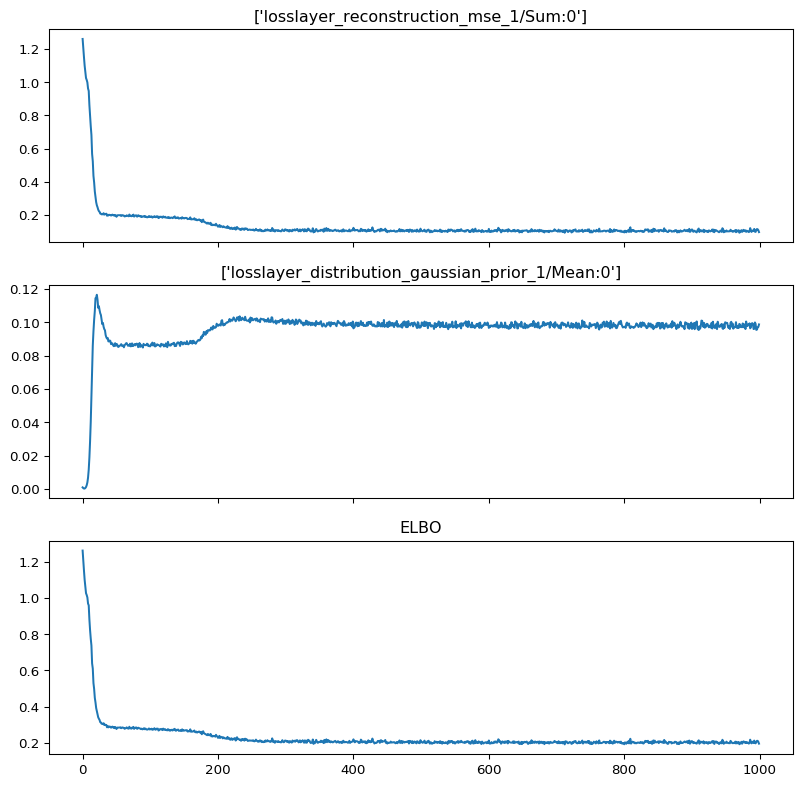

Build a model to project inputs on the latent space


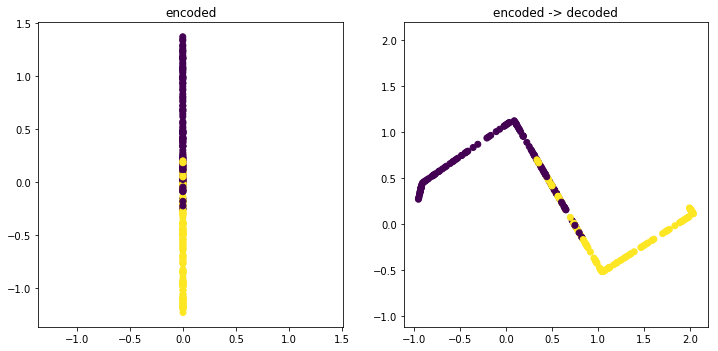

Project data to single dimension
Show the layer activation


/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


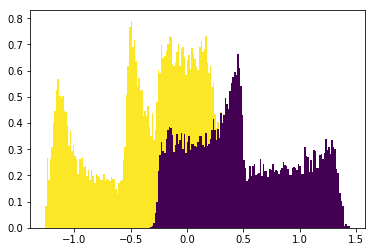

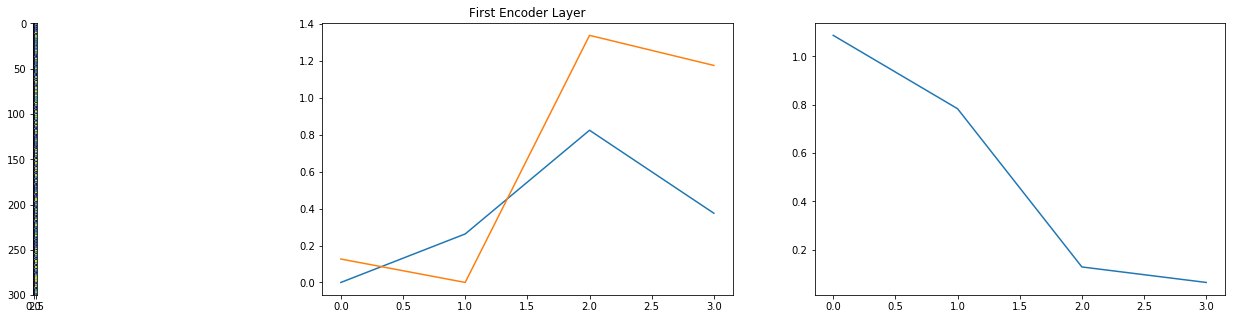

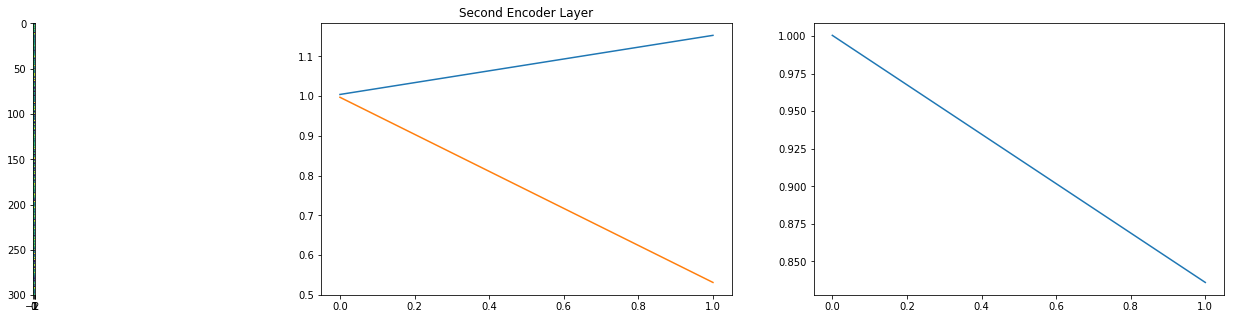

In [4]:
train_model(batch_size = 1024, original_dim = 2, intermediate_dim = 4, epochs = 1000, z_dim = 2, beta = .1)

Show the losses


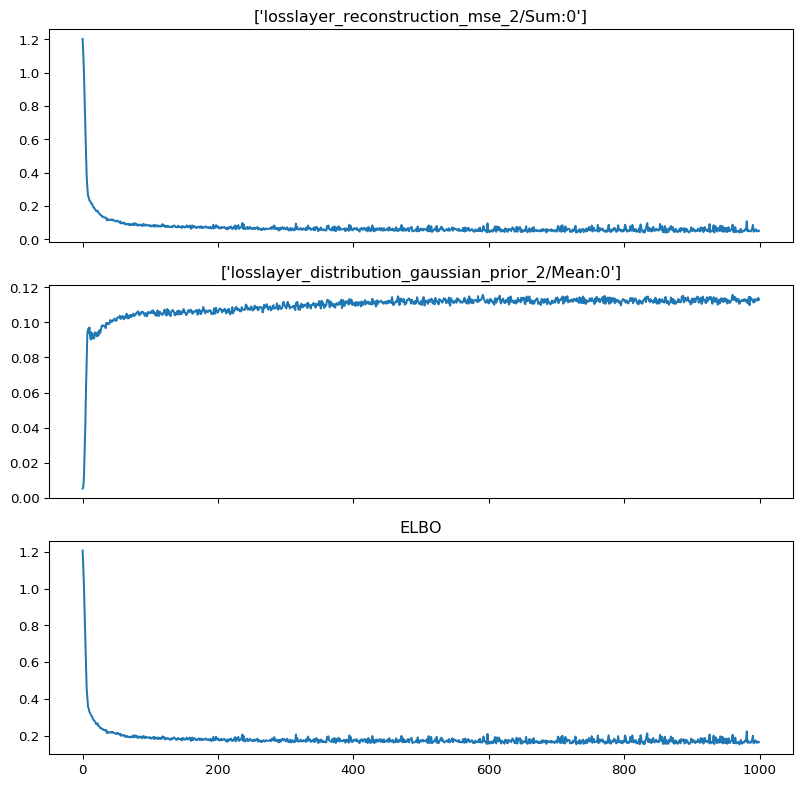

Build a model to project inputs on the latent space


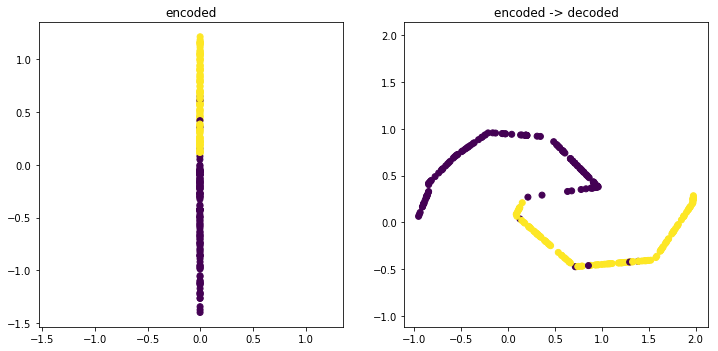

Project data to single dimension


/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


Show the layer activation


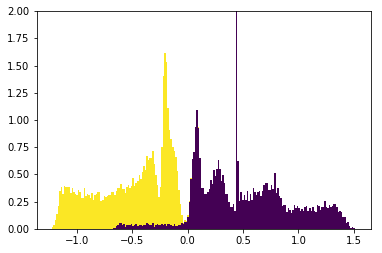

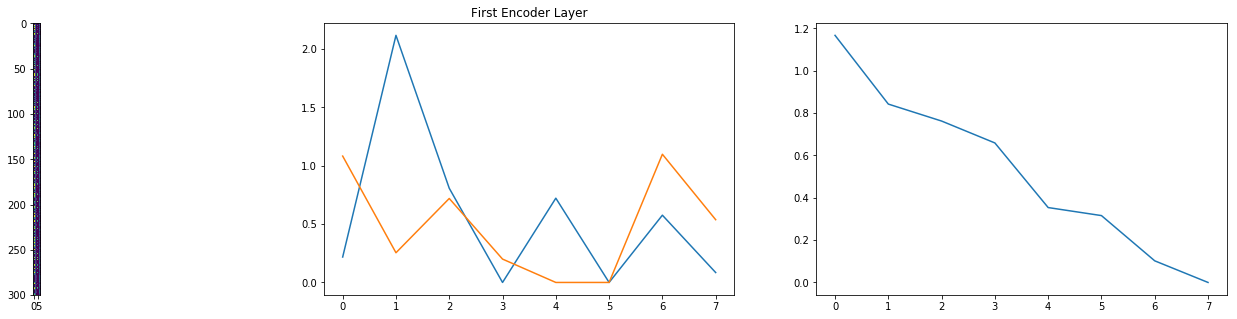

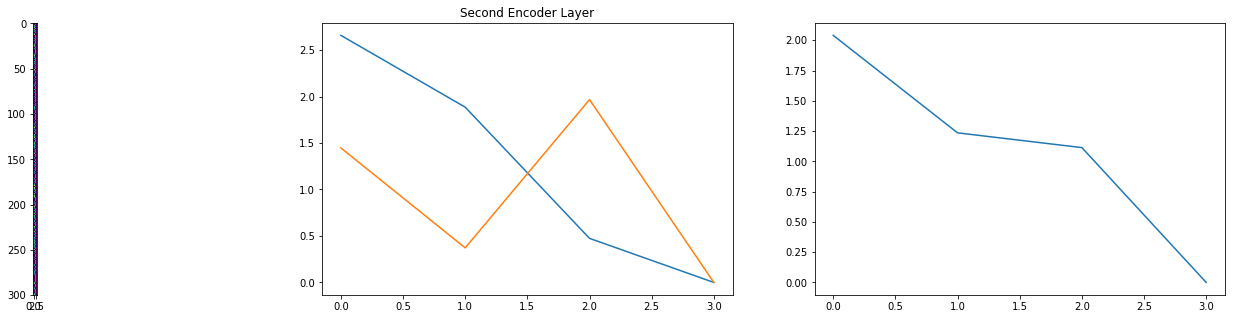

In [5]:
train_model(batch_size = 1024, original_dim = 2, intermediate_dim = 8, epochs = 1000, z_dim = 2, beta = .1)

Show the losses


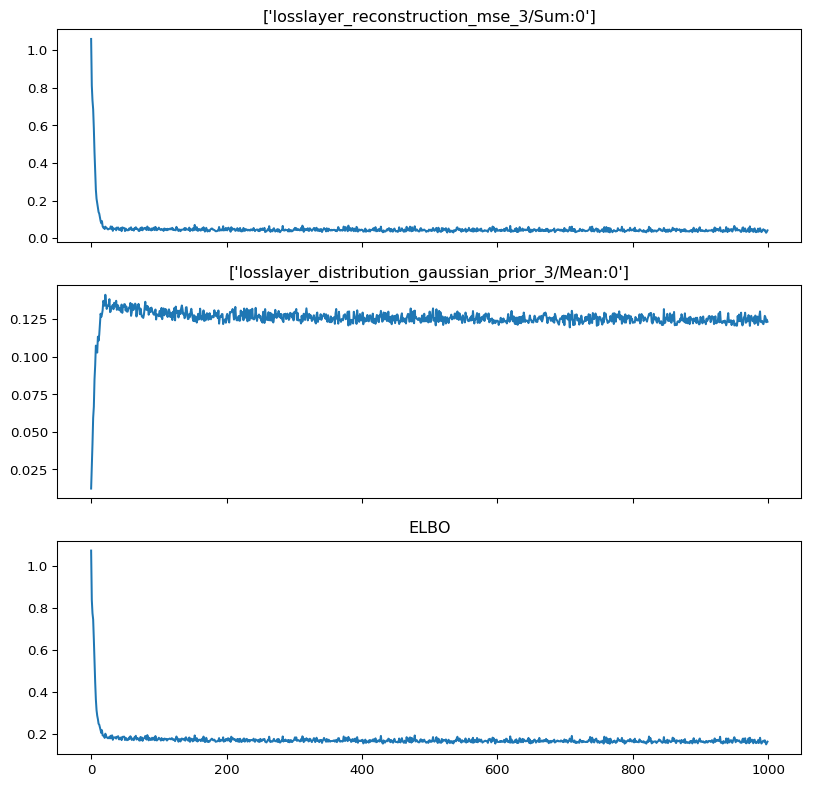

Build a model to project inputs on the latent space


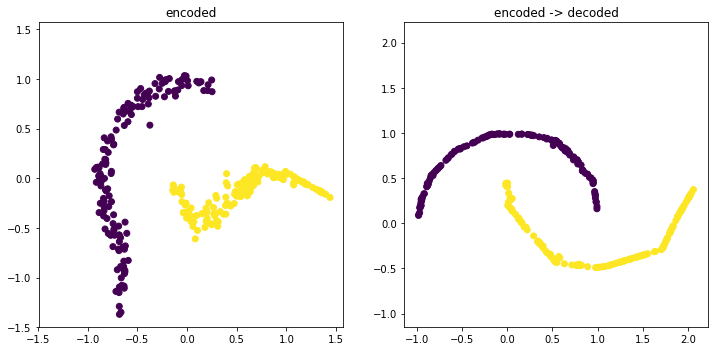

Project data to single dimension


/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


Show the layer activation


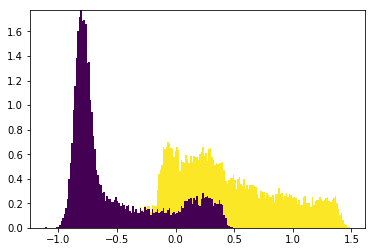

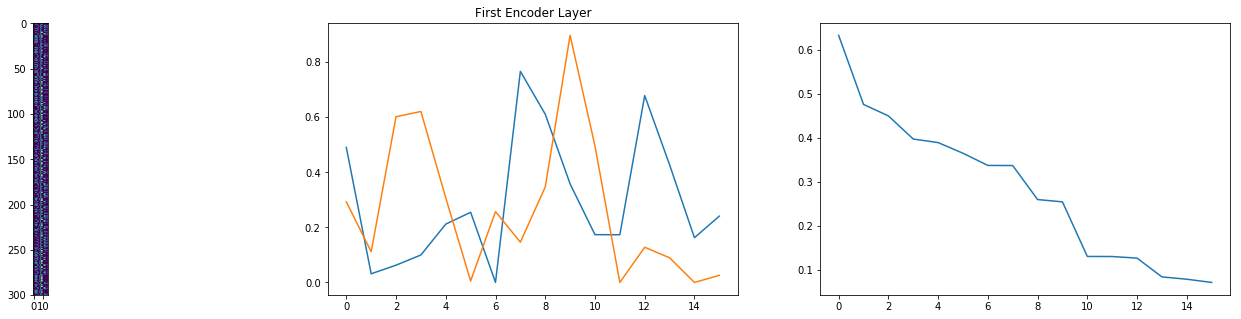

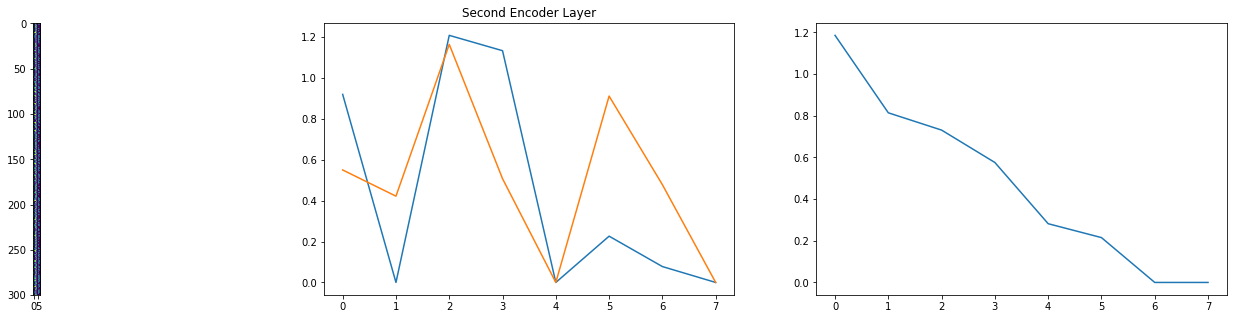

In [6]:
train_model(batch_size = 1024, original_dim = 2, intermediate_dim = 16, epochs = 1000, z_dim = 2, beta = .1)

Show the losses


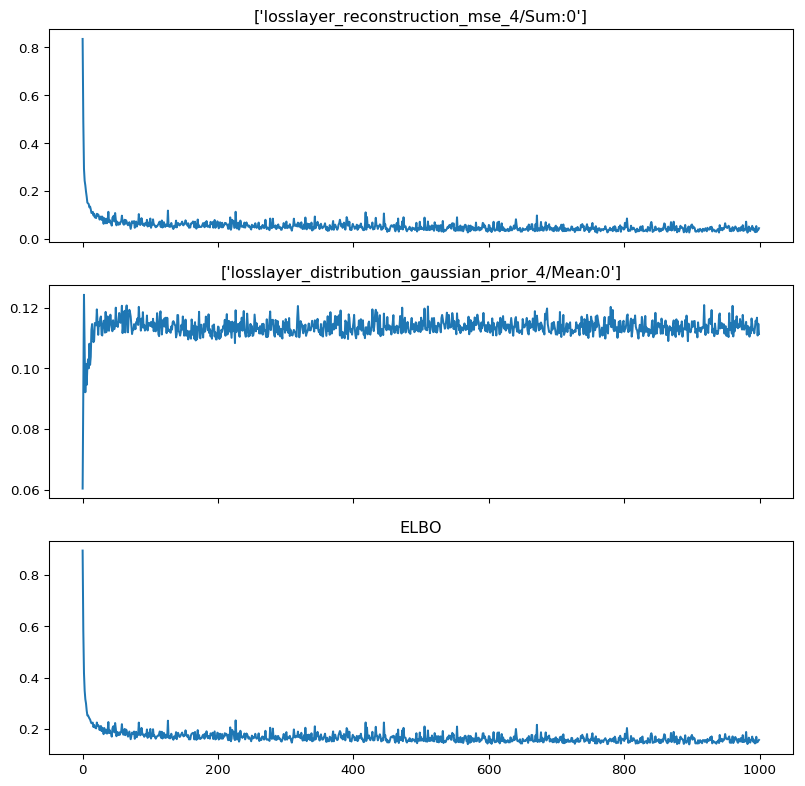

Build a model to project inputs on the latent space


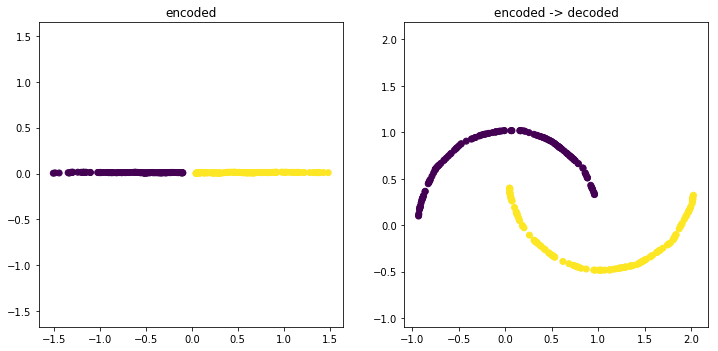

Project data to single dimension


/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


Show the layer activation


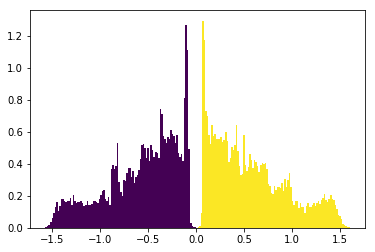

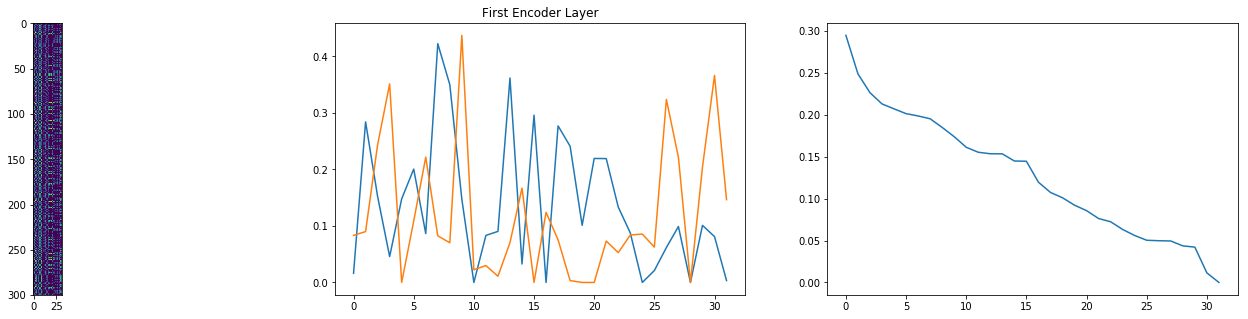

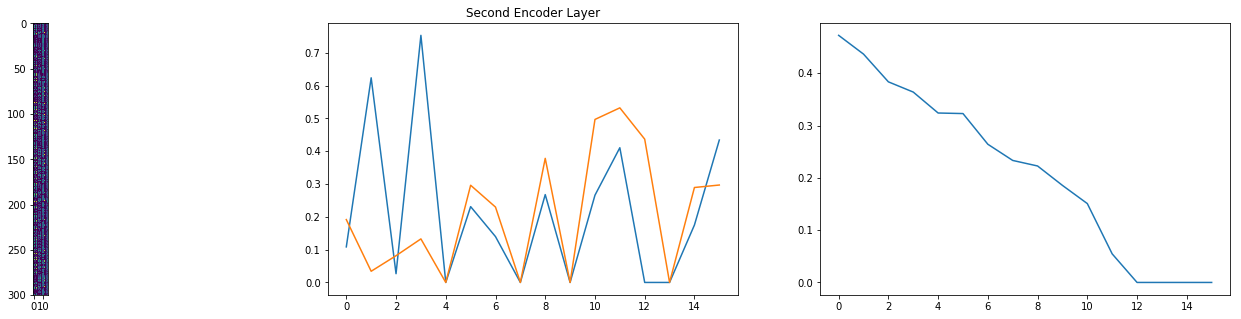

In [7]:
train_model(batch_size = 1024, original_dim = 2, intermediate_dim = 32, epochs = 1000, z_dim = 2, beta = .1)

Show the losses


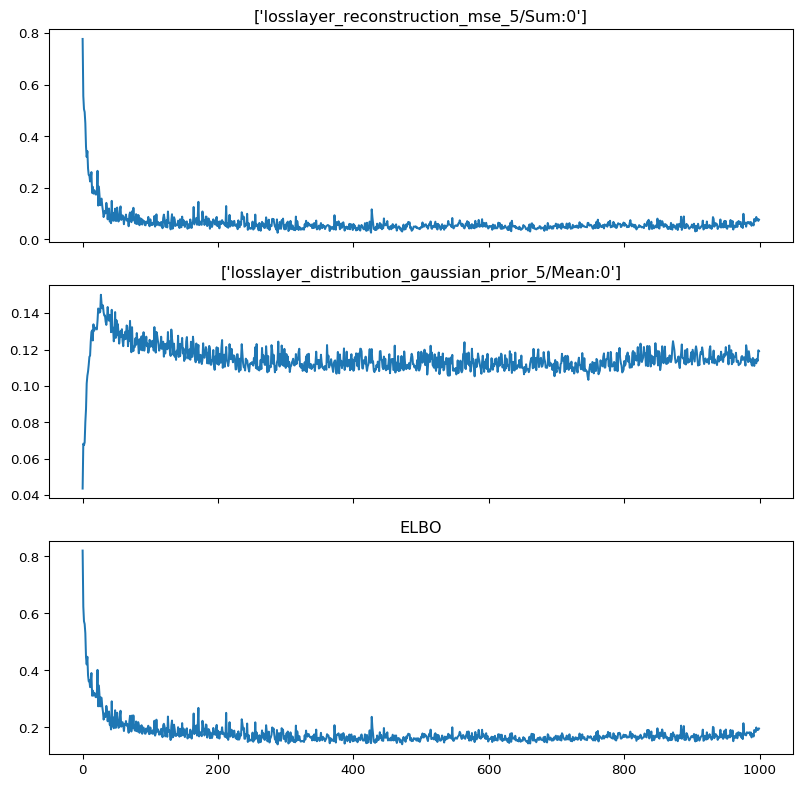

Build a model to project inputs on the latent space


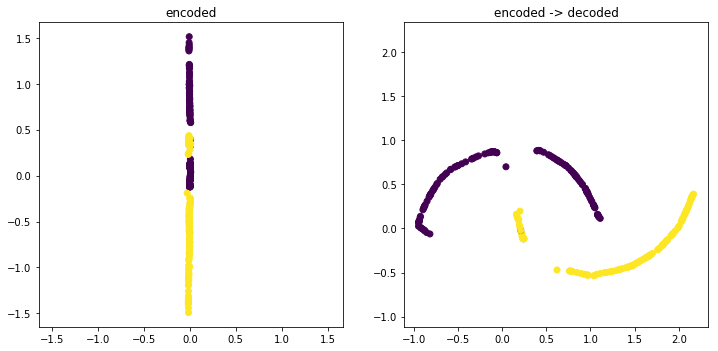

Project data to single dimension


/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


Show the layer activation


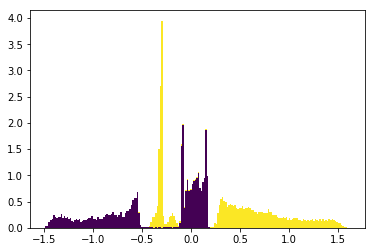

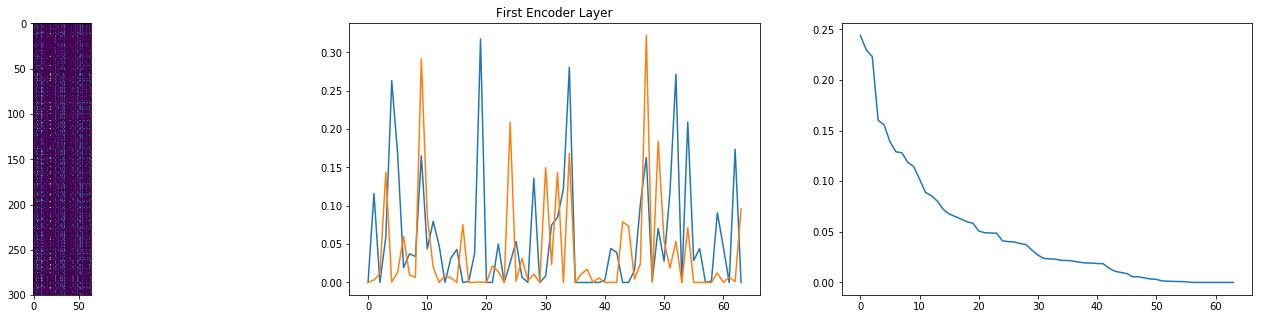

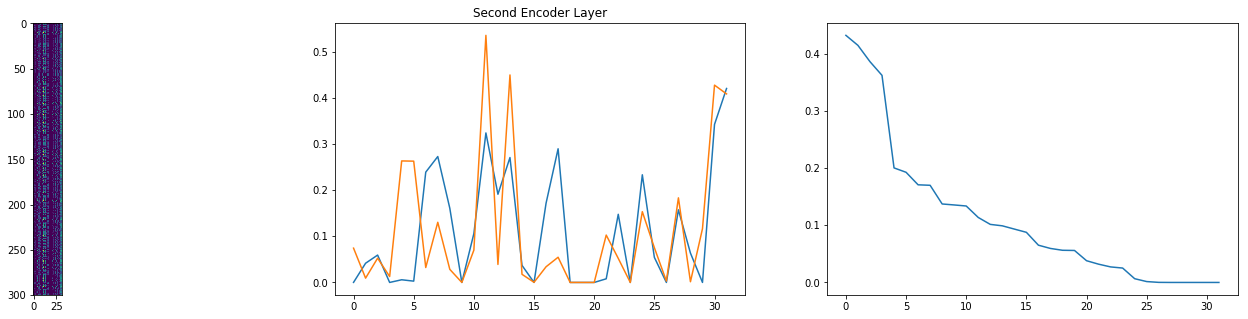

In [8]:
train_model(batch_size = 1024, original_dim = 2, intermediate_dim = 64, epochs = 1000, z_dim = 2, beta = .1)

Show the losses


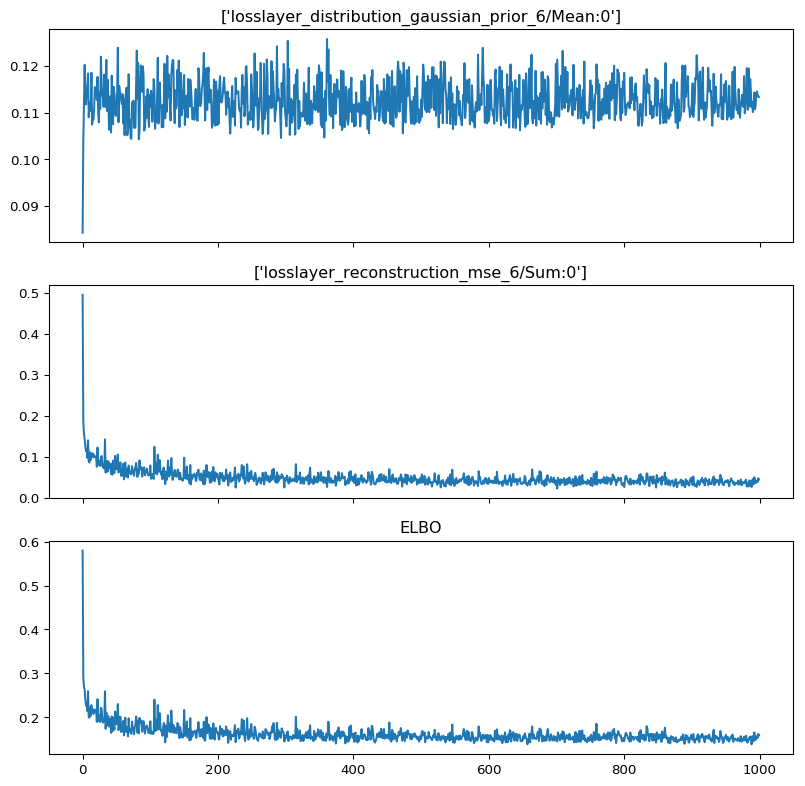

Build a model to project inputs on the latent space


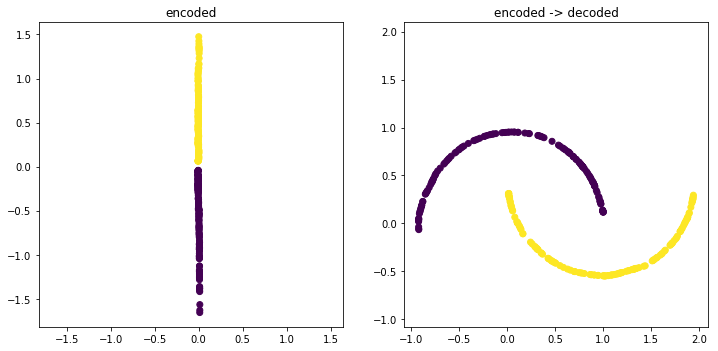

Project data to single dimension


/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


Show the layer activation


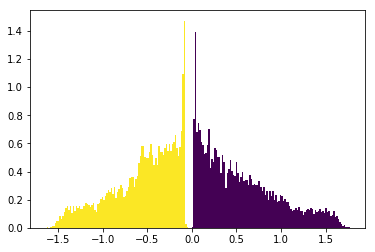

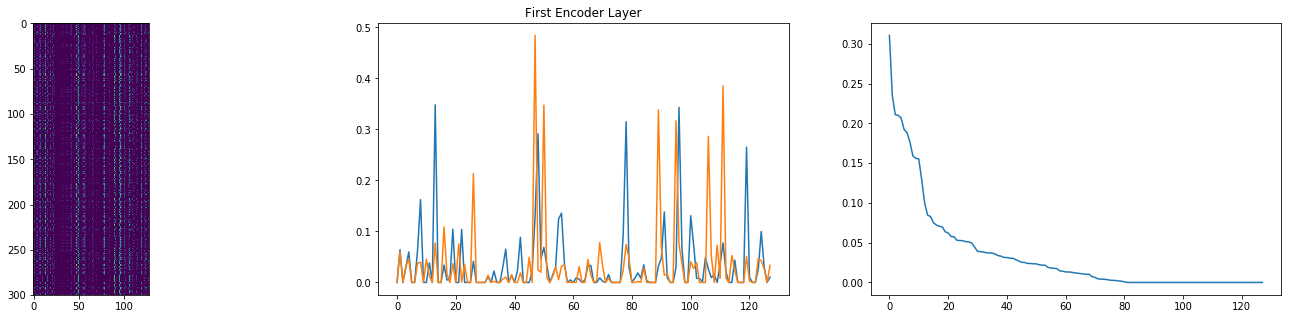

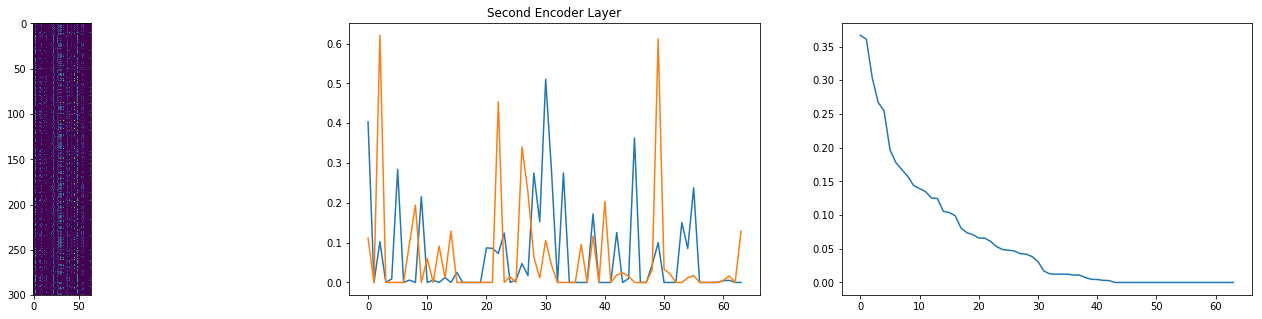

In [9]:
train_model(batch_size = 1024, original_dim = 2, intermediate_dim = 128, epochs = 1000, z_dim = 2, beta = .1)

Show the losses


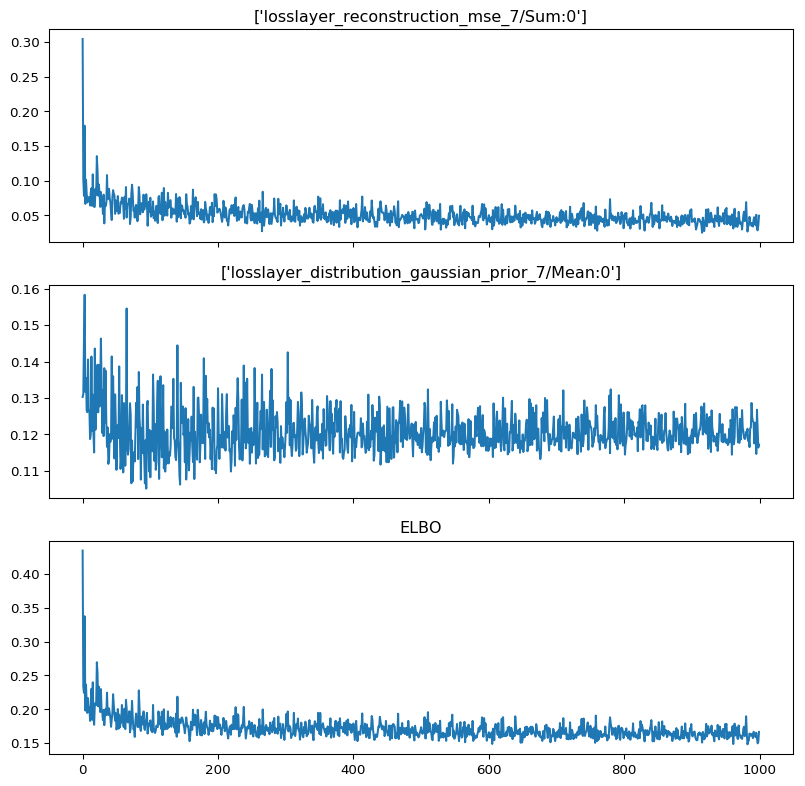

Build a model to project inputs on the latent space


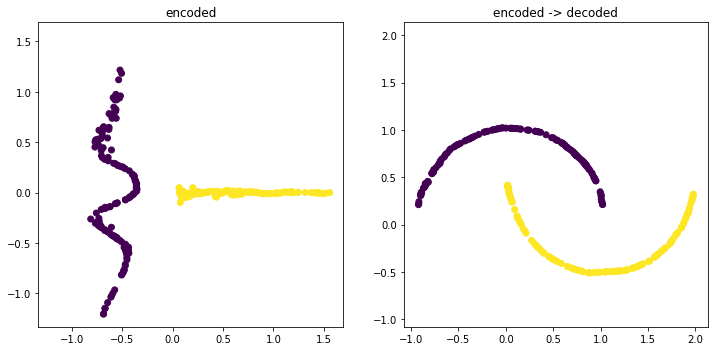

Project data to single dimension


/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


Show the layer activation


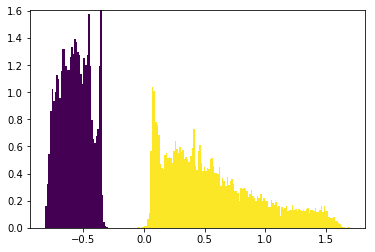

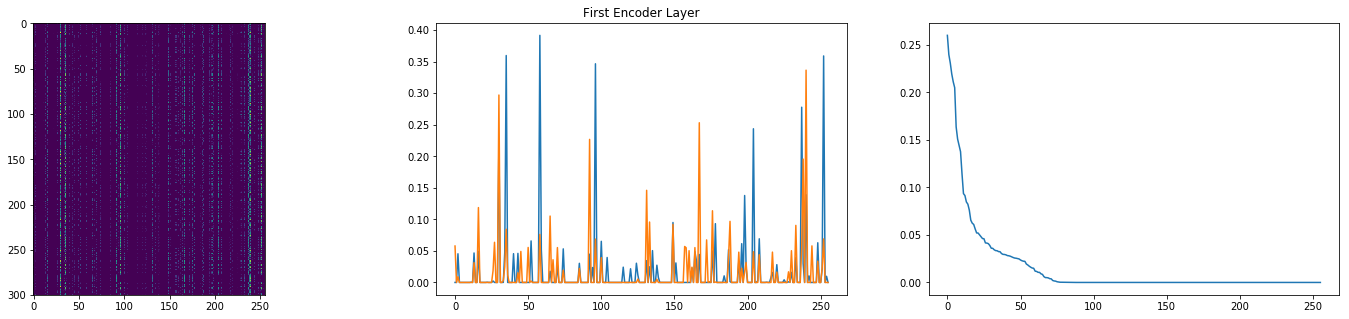

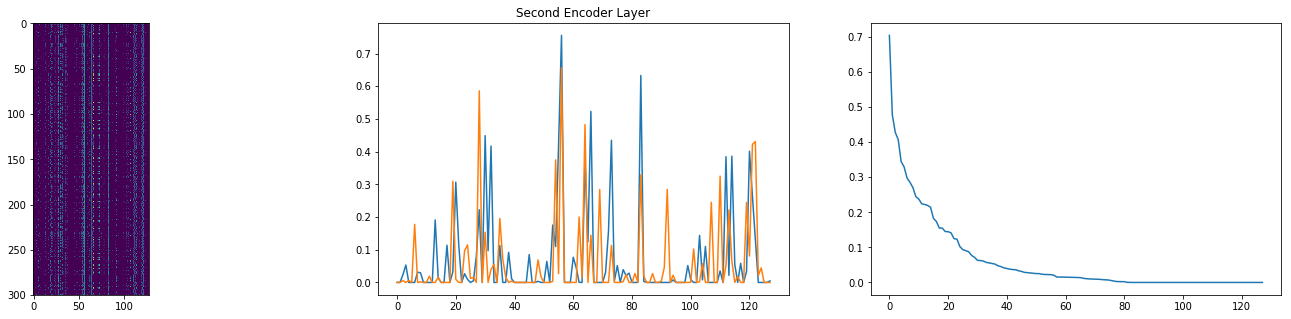

In [10]:
train_model(batch_size = 1024, original_dim = 2, intermediate_dim = 256, epochs = 1000, z_dim = 2, beta = .1)